# Machine Learning para DOA - Dregon Dataset

O objetivo aqui é utilizar regrassão para determinar a direção de chegada. Para isso, já extraí os delays referentes a todas as combinações de microfones do Dregon Dataset - Clean Speech.

O algoritmo usado para extrair os delays foi o delayDatasetCreator.py. Pode ser que a informação de todos os delays seja redundante, uma vez que o algoritmo determinístico usa só os delays em relação ao microfone da origem do espaço vetorial.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from math import sqrt, cos, sin, pi
from sklearn.linear_model import LinearRegression, LassoLars, RANSACRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

#### Abrindo o CSV com Pandas e separando as features das classificações 

O dataset tem as seguintes colunas:

Nome do arquivo WAV, Features, Azimutal Real, Elevação Real

In [2]:
dataset       = pd.read_csv("/home/dimi/Programming/IC2019/DOA/Datasets/dregonDelaysDataset.csv")
xReal         = np.array(dataset[dataset.columns[1:-2]])
yRealAzimutal = np.array(dataset[dataset.columns[-2]])
yRealElevacao = np.array(dataset[dataset.columns[-1]])

In [3]:
print(xReal[0], yRealAzimutal[0], yRealElevacao[0])

[ 12  12  22  18  17   7   6  -1  10   6   4  -5  -6  11   7   5  -5  -6
  -5  -6 -16 -17  -1 -11 -12  -9 -10  -1] 45 -30


#### Definindo algumas funções que vou precisar

In [4]:
def radParaGrau(angulo):
    return (angulo*180)/pi

def grauParaRad(angulo):
    return (angulo*pi)/180

def vetorUnitario(vetor):
    return vetor/np.linalg.norm(vetor)

def tempoParaAmostras(tempo, freqAmostragem):
    return tempo * freqAmostragem

## Treinando com dados fictícios

#### Criando os dados fictícios de treino

Os dados de treino não serão dados reais. Vou usar a conta do produto interno para verificar qual seria o delay ideal entre cada microfone. Assim, posso criar dados fictícios que representam o caso ideal, e com eles, treinar os regressores.

http://www.labbookpages.co.uk/audio/beamforming/delayCalc.html

In [5]:
# COORDENADAS ORIGINAIS
coordenadasMics = np.array([
    [0.0420, 0.0615, -0.0410],
    [-0.0420, 0.0615, 0.0410],
    [-0.0615, 0.0420, -0.0410],
    [-0.0615, -0.0420, 0.0410],
    [-0.0420, -0.0615, -0.0410],
    [0.0420, -0.0615, 0.0410],
    [0.0615, -0.0420, -0.0410],
    [0.0615, 0.0420, 0.0410]
])

In [36]:
# CRIANDO OS ARRAYS DE XTRAIN E YTRAIN
xTrain         = []
yTrainAzimutal = []
yTrainElevacao = []

# VOU PRECISAR DA FREQUENCIA DE AMOSTRAGEM DO DATASET
freqAmostragem = 44100

# VOU CALCULAR OS DELAYS COMO SE O SOM TIVESSE VINDO DAS SEGUINTES COMBINACOES
# DE AZIMUTAIS E ELEVACOES

# azimutaisDesejados = [45,60,75,90]
# elevacoesDesejadas = [-30,-15,0]
# for azimutalAtual in azimutaisDesejados:
#     for elevacaoAtual in elevacoesDesejadas:
for azimutalAtual in np.arange(0, 91, 10):
    for elevacaoAtual in np.arange(-90, 1, 10):
        
        # COLOCANDO NOS ARRAYS DE YTRAIN
        yTrainAzimutal.append(azimutalAtual)
        yTrainElevacao.append(elevacaoAtual)
        
        # TENHO QUE PASSAR PRA RADIANOS PRA FAZER AS CONTAS
        azimutalAtualRad = grauParaRad(azimutalAtual)
        elevacaoAtualRad = grauParaRad(elevacaoAtual)

        # PARA CADA COMBINAÇÃO DE MICROFONES
        linhaAtualXTrain = []
        for micI in range(0, 8):
            for micJ in range(micI + 1, 8):

                # COORDENADAS DA DIFERENCA DOS MICS
                coordenadasDiferenca = coordenadasMics[micI] - coordenadasMics[micJ]

                # COORDENADAS DO VETOR WAVEFRONT (JA VOU DEIXAR ELE UNITARIO)
                w = vetorUnitario(np.array([
                    cos(azimutalAtualRad)*cos(elevacaoAtualRad),
                    sin(azimutalAtualRad)*cos(elevacaoAtualRad),
                    sin(elevacaoAtualRad)
                ]))

                # CALCULANDO O PRODUTO INTERNO E DIVIDINDO PELA VELOCIDADE DO SOM
                delayTemporal = coordenadasDiferenca[0] * w[0]
                delayTemporal += coordenadasDiferenca[1] * w[1]
                delayTemporal += coordenadasDiferenca[2] * w[2]
                delayTemporal /= 340

                # VOU COLOCANDO OS RESULTADOS NA LINHA ATUAL DE XTRAIN
                linhaAtualXTrain.append(tempoParaAmostras(delayTemporal, freqAmostragem))
        
        # AGORA, JA POSSO COLOCAR A LINHA INTEIRA EM XTRAIN
        xTrain.append(linhaAtualXTrain)
        
# PASSANDO TUDO PRA NUMPY5
xTrain = np.array(xTrain).astype(int)
yTrainAzimutal = np.array(yTrainAzimutal)
yTrainElevacao = np.array(yTrainElevacao)

Verificando que os dados fictícios são parecidos com os dados reais

In [34]:
indexReal     = 10
indexFicticio = 4

print(yRealAzimutal[indexReal], yRealElevacao[indexReal])
print(yTrainAzimutal[indexFicticio], yTrainElevacao[indexFicticio])
print("\n\n\n")

for i, feature in enumerate(xReal[indexReal]):
    print(feature, "\t", xTrain[indexFicticio][i])

60 -15
60 -15




8 	 8
10 	 8
22 	 20
21 	 18
18 	 16
10 	 10
4 	 3
2 	 0
13 	 12
12 	 10
10 	 8
2 	 1
-4 	 -4
11 	 11
10 	 10
8 	 7
0 	 1
-6 	 -4
-1 	 -1
-4 	 -4
-11 	 -10
-17 	 -16
-2 	 -2
-10 	 -8
-17 	 -14
-8 	 -6
-14 	 -12
-6 	 -6


#### Treinando o regressor e prezidendo dados

In [37]:
# PRIMEIRO COM O AZIMUTAL
regressorAzimutal = LinearRegression().fit(xTrain, yTrainAzimutal)
yPredAzimutal = regressorAzimutal.predict(xReal)

for i, predicao in enumerate(yPredAzimutal):
    print(yRealAzimutal[i], predicao)

45 55.63241747408091
90 88.49189769645378
60 56.58551317587522
75 82.86782914247749
60 68.36803847514051
45 39.07923320253231
60 72.95501880296953
45 52.08603112423505
90 84.42178409114487
90 87.4703663990154
60 66.66448537074182
60 62.20721456267512
75 73.13524307962288
45 55.231774415445386
75 78.65299849082857
90 89.95863974509201
60 62.11187134438064
60 73.1628294606847
60 71.10490486153508
75 76.48982982144986
90 78.0740372478586
75 87.35105452116466
75 83.59675182221622
60 55.21050115438214
90 95.31575827521371
45 43.00687052474884
90 91.33365176658502
75 71.36106802538504
90 101.02772560564114
75 92.08734226947251
75 84.48528132038851
90 101.23327741640904
45 45.41114054407722
45 44.604280751775796
60 73.56904619435072
75 74.99403194913967
60 73.79144439988454
45 42.18947745767998
45 52.28524554419343
75 81.33096677835161
75 74.72630939629734
90 74.16493595429603
75 73.93029476722072
60 52.06431678126988
45 48.440663321039665
75 78.65299849082857
75 73.13524307962288
90 93.43155

In [9]:
# AGORA COM A ELEVACAO
regressorElevacao = LinearRegression().fit(xTrain, yTrainElevacao)
yPredElevacao = regressorAzimutal.predict(xReal)

for i, predicao in enumerate(yPredElevacao):
    print(yRealElevacao[i], "\t", predicao)

-30 	 55.63241747408091
-15 	 88.49189769645378
-30 	 56.58551317587522
-15 	 82.86782914247749
0 	 68.36803847514051
-30 	 39.07923320253231
0 	 72.95501880296953
-15 	 52.08603112423505
0 	 84.42178409114487
-15 	 87.4703663990154
-15 	 66.66448537074182
-15 	 62.20721456267512
-30 	 73.13524307962288
-15 	 55.231774415445386
-15 	 78.65299849082857
0 	 89.95863974509201
-30 	 62.11187134438064
-15 	 73.1628294606847
0 	 71.10490486153508
0 	 76.48982982144986
-15 	 78.0740372478586
0 	 87.35105452116466
-15 	 83.59675182221622
-30 	 55.21050115438214
-15 	 95.31575827521371
-15 	 43.00687052474884
0 	 91.33365176658502
0 	 71.36106802538504
0 	 101.02772560564114
0 	 92.08734226947251
-15 	 84.48528132038851
-15 	 101.23327741640904
-15 	 45.41114054407722
0 	 44.604280751775796
-15 	 73.56904619435072
-15 	 74.99403194913967
0 	 73.79144439988454
-15 	 42.18947745767998
0 	 52.28524554419343
-30 	 81.33096677835161
0 	 74.72630939629734
-30 	 74.16493595429603
-30 	 73.930294767220

## Treinando com dados reais

### Linear Regression

In [38]:
objLS = LinearRegression()

xTrain, xTest, yTrain, yTest = tts(xReal, yRealAzimutal, test_size=0.5)
    
objLS.fit(xTrain, yTrain)
    
yPred = objLS.predict(xTest)

for i, predicao in enumerate(yPred):
    print(yTest[i], predicao)

45 43.51477528856333
60 60.07157500824117
75 77.1688894529554
90 91.77818115800743
60 60.84622912720741
45 45.66508079660877
75 74.72300461670116
75 74.66674655401636
75 74.34030562585842
60 60.63599769566778
45 43.99929775540017
45 49.69220172984709
75 73.31082459404831
45 43.20443225068479
75 75.18450408913347
90 87.45400118179859
60 59.89706402094913
60 61.25029663064558
75 74.82457475548335
45 46.204149414939344
60 59.72869841272575
90 88.88859524705373
90 89.35647903503418
60 58.47582998265025
60 59.9377955878196
90 87.4151485952529
90 86.83230822215305
75 76.27002960950229
60 59.89614520800163
45 46.86792193433344
90 88.09297367153403
90 90.57415447540927
90 91.48510782630767
45 45.17263329343136
45 44.883660835896926
60 60.10978825094352
90 90.73572363243917
60 58.18853029267467
60 58.924969976704894
45 45.40564375133081
45 43.079479673280595
90 88.845651185109
45 45.24284046239322
90 91.68827085347901
45 45.63262968366864
90 91.35054577508706
90 91.4089883955586
45 46.359236501

In [39]:
yTrain

array([45, 90, 45, 90, 45, 75, 90, 45, 90, 75, 45, 90, 75, 75, 75, 60, 75,
       45, 60, 60, 60, 45, 45, 60, 75, 90, 90, 60, 90, 60, 45, 90, 60, 90,
       60, 60, 60, 45, 45, 45, 75, 75, 45, 90, 45, 90, 90, 90, 60, 45, 75,
       75, 90, 75, 60, 45, 75, 75, 75, 75, 60, 60, 75, 45, 90, 90, 60, 60,
       75, 60, 45, 45, 45, 75, 75, 45, 60, 90, 60, 45, 75, 45, 60, 45, 60,
       90, 60, 90, 90, 75, 75, 90, 60, 75, 60, 90])

(array([24.,  0.,  0., 25.,  0.,  0., 24.,  0.,  0., 23.]),
 array([45. , 49.5, 54. , 58.5, 63. , 67.5, 72. , 76.5, 81. , 85.5, 90. ]),
 <a list of 10 Patch objects>)

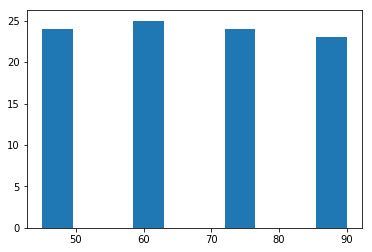

In [46]:
import matplotlib.pyplot as plt
plt.hist(yTrain)

(array([24.,  0.,  0., 23.,  0.,  0., 24.,  0.,  0., 25.]),
 array([45. , 49.5, 54. , 58.5, 63. , 67.5, 72. , 76.5, 81. , 85.5, 90. ]),
 <a list of 10 Patch objects>)

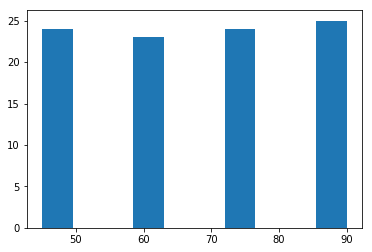

In [47]:
plt.hist(yTest)

### Lasso Lars

In [11]:
objLL = LassoLars()

xTrain, xTest, yTrain, yTest = tts(xReal, yRealAzimutal, test_size=0.5)
    
objLL.fit(xTrain, yTrain)
    
yPred = objLL.predict(xTest)

for i, predicao in enumerate(yPred):
    print(yTest[i], predicao)

60 64.01159712113689
45 57.83372961717569
90 77.58959979598322
60 64.01159712113689
75 71.41173229202204
60 64.01159712113689
60 64.01159712113689
45 57.83372961717569
75 71.41173229202204
90 76.35254786920562
45 57.83372961717569
75 70.18207249517125
60 64.01159712113689
45 57.83372961717569
45 59.07817367388012
75 70.18207249517125
45 57.84112174710252
60 64.01159712113689
60 64.00420499121006
60 64.01159712113689
90 77.58959979598322
90 75.12288807235484
45 59.070781543953295
90 76.35254786920562
90 75.12288807235484
90 75.12288807235484
75 70.18207249517125
45 57.83372961717569
60 64.01159712113689
75 70.18207249517125
45 57.84112174710252
60 64.00420499121006
90 76.35993999913245
90 76.35254786920562
90 76.35254786920562
60 64.01159712113689
60 64.01159712113689
75 70.18207249517125
90 76.35254786920562
60 64.01159712113689
75 70.18207249517125
45 57.83372961717569
45 57.83372961717569
75 71.41173229202204
45 57.83372961717569
60 64.00420499121006
45 57.83372961717569
90 75.122888

### Bayesian Ridge

In [12]:
objBR = BayesianRidge()

xTrain, xTest, yTrain, yTest = tts(xReal, yRealAzimutal, test_size=0.9)
    
objBR.fit(xTrain, yTrain)
    
yPred = objBR.predict(xTest)

for i, predicao in enumerate(yPred):
    print(yTest[i], predicao)

90 93.00276180992307
45 44.0210899090482
75 74.84372497785407
60 60.20046531889784
45 44.07648981051348
90 87.25725825252727
45 42.757285206702775
90 93.10769649056783
45 44.0210899090482
75 73.30892238854598
60 58.40118552279107
60 56.99548757228585
60 62.119977831376275
90 92.72288269261972
75 75.00000062464183
45 41.93206074788831
90 92.9352966201988
45 43.635177812864
75 74.9999145442627
75 77.48173965754995
90 91.45515154327249
75 72.73592208393804
90 92.41035831837314
75 77.8965867812102
60 57.6302969376265
60 59.291844854559905
75 76.15196403350443
45 45.518768490112706
60 59.495877614480165
45 44.351287073599984
45 44.367370260630686
45 46.66302184534636
75 74.55994530125717
60 58.79212192377499
90 91.8096329483052
75 75.00000062464183
60 59.65277369045417
45 44.09407879341651
90 91.707111461117
75 75.35047347113826
45 48.96493900976979
45 43.04155644311839
75 74.25695175282081
75 74.3932948438773
45 43.35342968561357
60 60.394524949698294
45 45.646408241405744
45 44.7278218438